# Imports and function definitions

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [2]:
def build_table(conf_matrix):
    """
    Given a confusion matrix, return a dataframe with false positives, false negatives and overall error in percentage.
    """ 
    false_positive = []
    false_negative = []
    error = []
    
    for conf_matrix_i in conf_matrix:
        tn, fp, fn, tp = conf_matrix_i.ravel()
        false_positive.append(fp / np.sum(conf_matrix_i) * 100)
        false_negative.append(fn / np.sum(conf_matrix_i) * 100)
        error.append((fp+fn) / np.sum(conf_matrix_i) * 100)

    results = {
        'False positive (%)' : false_positive,
        'False negative (%)' : false_negative,
        'Overall error (%)' : error
    }
    
    index = ['Fold ' + str(i + 1) for i in range(len(error))]
    df = pd.DataFrame(results, index=index)
    df.loc['Mean'] = df.mean()
    
    return df

def train_test_clf(x, y, clf, n_folds=7):
    """
    Given a classifier clf, features x and target values y, it trains and predict a model using n_fold cross validation.
    """
    conf_matrix = []
    kf = KFold(n_splits=n_folds, shuffle=True)
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        confusion_matrix_i = confusion_matrix(y_test, y_pred)
        conf_matrix.append(confusion_matrix_i) 
        
    return conf_matrix

---

# Data Analysis
This notebook analyses spambase data set from [UCI respository](http://archive.ics.uci.edu/ml/datasets/spambase)

First, data is loaded with pandas and we can see that there are 57 features with last column corresponding to the target value (1 is spam, 0 no spam).

In [3]:
df = pd.read_csv('spambase.data', header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


We can observe that all data types are numerical.

In [4]:
df.dtypes.value_counts()

float64    55
int64       3
dtype: int64

And there are no missing values.

In [5]:
sum(df.isna().any())

0

Next we observe that values are not normalized, there is a huge difference in standard deviation and maximum values.

In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


This is not important for models like tree ensembles but it will affect other models as SVM. We normalize x data therefore.

In [7]:
x = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:,-1])
x = normalize(x)

Next, once we have already data preprocessed, it is time to choose our machine learning models for classification.
If there is no more knowledge about what is the most suitable model and I had to pick only one, I will go directly with XGBoost or any other boosting method based on decision trees.
In this notebook five different models have been compared:
- XGBoost
- Naive Bayes
- Random Forest
- Support Vector Machine
- KNearest Neighbors

In [8]:
classifiers = {
    'XGBoost' : XGBClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Random Forest' : RandomForestClassifier(n_estimators=5),
    'SVM' : SVC(gamma='scale'),
    'KNN' : KNeighborsClassifier()
}

For every model we train it with 7 fold cross validation and store the result of the test prediction. 

In [9]:
results = {}
for clf_name, clf in classifiers.items():
    conf_matrix = train_test_clf(x, y, clf, n_folds=7)
    results[clf_name] = build_table(conf_matrix)

Next, we want to compare which performs better and we can see that XGBoost is the best model in this case with an overall error of around 5-6%.
This are only preliminar results, as we have not tuned the hyperparameters in models which affect greatly the result. Some examples of this parameters are gamma in the case of SVM or the metric distance for KNN. 
This is one of the advantages of Boosting methods and trees as there are not many parameters to adjast and the model performs well in a wide range of data. 

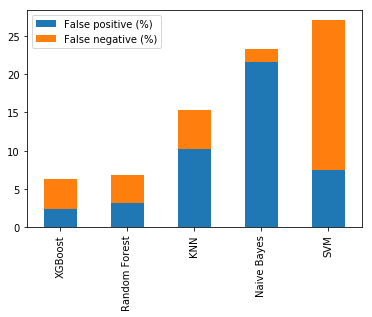

In [10]:
comparison = []
for res in results.values():
    comparison.append(res.loc['Mean'])
comp = pd.DataFrame(comparison, index=classifiers.keys())
comp.sort_values('Overall error (%)').iloc[:, :-1].plot.bar(stacked=True)

Let us analyze in more detail the results of our model XGBoost showing a table with the results of the 7 folds and the average result

In [11]:
table = results['XGBoost'].round(3)
table

,False positive (%),False negative (%),Overall error (%)
Fold 1,2.888,4.711,7.599
Fold 2,1.976,3.647,5.623
Fold 3,2.131,2.588,4.718
Fold 4,1.826,4.262,6.088
Fold 5,2.131,3.196,5.327
Fold 6,2.588,3.957,6.545
Fold 7,3.196,5.023,8.219
Mean,2.391,3.912,6.303


One of the advantages of tree classifiers is that we can analyze the feature importance. Let us see the highest 10 features by importance:

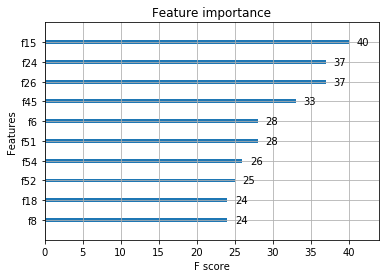

In [12]:
plot_importance(classifiers['XGBoost'], max_num_features=10 )
pyplot.show()

Top 3 features are 24, 26 and 15, which corresponds to word_freq_hp, word_freq_george and word_freq_free. 
First two features does not make much sense for me but the third one, free, it is obvious its relation with spam. Fifth feature(f6), char_freq_$ is also a good clue.


# Results
Using XGBoost we have built a model for spam detection with an overall error of 5 to 6%.

# Next steps
We have not tuned the hyperparameters for models, so to really compare their error and to obtain better results, the next step will be to find the optimal of these parameters doing a search with cross validation.
Furthermore, here are some ideas:
- We can see that boosting yields a model with equal parts of false positives and false negatives. We could try to combine these model and create an ensemble with a model that has a different ratio of these errors.
- For example, Naive Bayes shows a small false negative error, which we could use

# Just for fun
I have implemented different machine algorithms from scratch using only numpy library, which can be seen in [my repository](https://github.com/MarinAlejandro/machine-learning). Next lines uses the implementation of Adaboost.

In [ ]:
import sys
sys.path.append("..")

In [14]:
from metrics import accuracy
from boosting import AdaBoost

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
n_classifiers = 20
clf = AdaBoost(n_classifiers)
clf.train(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_i = accuracy(y_test, y_pred)
print(f'Adaboost with {n_classifiers} classifiers accuracy: {accuracy_i :.2f}')

Adaboost with 20 classifiers accuracy: 0.77


Not really impressive, but this predictions are done combining a simple stump!